In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
import scanpy as sc
import anndata
import pandas as pd
import tools
import logging
import mira
import warnings

warnings.filterwarnings('ignore')

/home/haiyi/anaconda3/envs/halo2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## model setup
atac_model = mira.topics.AccessibilityTopicModel(counts_layer='counts',
                                                 dataset_loader_workers = 3)

rna_model = mira.topics.ExpressionTopicModel(
    endogenous_key='endog',
    exogenous_key='endog',
    counts_layer='counts',
    seed = 0,
    hidden=64, # to make the tutorial faster. In practice, use the default of 128!
)          


rna_model = mira.topics.ExpressionTopicModel.load('MIRA/hair_rna_topic_model.pth')
atac_model = mira.topics.AccessibilityTopicModel.load('MIRA/hair_atac_topic_model.pth')

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [3]:
rna_data = anndata.read_h5ad("mira-datasets/shareseq_annotated_data/rna_data.joint_representation.rp_modeled.h5ad")
atac_data = anndata.read_h5ad("mira-datasets/shareseq_annotated_data/atac_data.joint_representation.motif_calls.tss_annotated.h5ad")

In [4]:
## loading the data
rna_data = anndata.read_h5ad("data/datasets/mouse_hair_rna_interim.h5ad")
atac_data =  anndata.read_h5ad("data/datasets/mouse_hair_atac_interim.h5ad")

In [24]:
rna_model.predict(rna_data)
# rna_data.write_h5ad("data/datasets/mouse_hair_")

Predicting latent vars: 100%|██████████| 13/13 [00:01<00:00, 10.71it/s]
INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


In [25]:
atac_data.layers["counts"] =atac_data.X.copy()
rna_data.layers["counts"] =rna_data.X.copy()


In [26]:
atac_model.predict(atac_data)

Predicting latent vars: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]
INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


In [27]:
rna_data.write_h5ad("data/datasets/mouse_hair_mira_rna.h5ad")
atac_data.write_h5ad("data/datasets/mouse_hair_mira_atac.h5ad")


In [3]:
rna_data = sc.read_h5ad("data/datasets/mouse_hair_mira_rna.h5ad")
atac_data = sc.read_h5ad("data/datasets/mouse_hair_mira_atac.h5ad")

In [34]:
mira.datasets.mm10_chrom_sizes()
mira.datasets.mm10_tss_data()

INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/mm10.chrom.sizes
INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/mm10_tss_data.bed12


In [38]:
## ATAC data get TSS annotation

mira.tl.get_distance_to_TSS(atac_data,
                            tss_data='mira-datasets/mm10_tss_data.bed12',
                            genome_file='mira-datasets/mm10.chrom.sizes')

INFO:mira.tools.connect_genes_peaks:Finding peak intersections with promoters ...
INFO:mira.tools.connect_genes_peaks:Calculating distances between peaks and TSS ...
INFO:mira.tools.connect_genes_peaks:Masking other genes' promoters ...
INFO:mira.adata_interface.rp_model:Added key to var: distance_to_TSS
INFO:mira.adata_interface.rp_model:Added key to uns: distance_to_TSS_genes


In [23]:
atac_data.write_h5ad("data/datasets/mouse_hair_mira_atac.h5ad")

In [5]:
del rna_data.obsm["X_topic_compositions"]

In [4]:
rna_data.var.index = rna_data.var.index.str.upper()
rp_args = dict(expr_adata = rna_data, atac_adata= atac_data)
rp_genes = list(rna_model.features[rna_model.highly_variable])
rp_genes = [str(e).upper() for e in rp_genes]
lgenes = ['Gna12', 'Dmpk', 'Ubtf', 'Nfe2l3', 'Cspp1', 'Wdr47', 'Ptpra', 'Mfsd2a',
       'Nedd9', 'Lrp4', 'Myo9a', 'Tfap2b', 'Zfand5', 'Hs3st3b1', 'Orc1',
       'Inpp5f', 'Lama5', 'Akap10', 'Mylk', 'Heg1', 'Agl', 'Safb2', 'Brd9',
       'Rnf180', 'Itgb5', 'Bmp2k', 'Fnbp1l', 'Cpt1a', 'Ccnt1', 'Slc7a6'] + ['Mt2', 'Krt23', 'Braf', 'Slc4a7', 'Lonrf3', 'Fam126b', 'Gpatch1',
       'Sdf4', 'Cers4', 'R3hdm2', 'Nbea', 'Rnf10', 'Ppp1r14c', 'Kremen1',
       'Nav2', '5031439G07Rik', 'Ythdf1', 'Galnt3', 'Setd7', 'Spata5',
       'Arhgef10l', 'Cep128', 'Ltbp3', 'Ranbp1', 'Atg7', 'Tcf3', 'Ddx52',
       'BC005561', 'Psrc1', 'Chd3']
irs_genes = ["CALM2", "CTSB"]       
lgenes = [str(e).upper() for e in lgenes]

rp_genes = rp_genes + lgenes
# rp_genes=["Chd3"]

In [5]:
litemodel = mira.rp.LITE_Model(expr_model = rna_model,
                              accessibility_model=atac_model,
                              counts_layer='counts',
                              genes = rp_genes)

In [51]:
litemodel.fit(**rp_args, n_workers=4,
              callback = mira.rp.SaveCallback("rpmodels/hair/"))

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
Calculating softmax summary data: 100%|██████████| 13/13 [00:00<00:00, 599.06it/s]
INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
Calculating softmax summary data: 100%|██████████| 13/13 [00:01<00:00, 11.79it/s]
INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
Fitting models:   1%|          | 6/1019 [00:00<02:13,  7.59it/s]

Fitting models:   2%|▏         | 19/1019 [00:05<03:29,  4.78it/s]

RuntimeError: Parent directory rpmodels/hair/2 does not exist.

In [6]:
litemodel.load("rpmodels/hair/")

In [7]:
rna_data.var.index = rna_data.var.index.str.upper()
rna_data.obs["latent_time_cat"] = pd.cut(rna_data.obs['latent_time'], 20, labels=[str(i) for i in range(20)])
rna_data.obs["latent_time_2"] = pd.cut(rna_data.obs['latent_time'], 50, labels=[str(i) for i in range(50)])
rna_data.obs["latent_time_10"] = pd.cut(rna_data.obs['latent_time'], 10, labels=[str(i) for i in range(10)])
rna_data.obs["latent_time_3"] = pd.cut(rna_data.obs['latent_time'], 5, labels=[str(i) for i in range(5)])
rna_data.obs["latent_time_8"] = pd.cut(rna_data.obs['latent_time'], 8, labels=[str(i) for i in range(8)])
rna_data.obs["latent_time_6"] = pd.cut(rna_data.obs['latent_time'], 6, labels=[str(i) for i in range(6)])

In [8]:
### Plot local genes and local peaks
from scipy.sparse import csr_matrix
from scipy.sparse import diags


def tfidf_norm(adata_atac, scale_factor=1e4):
    """TF-IDF normalization.
    This function normalizes counts in an AnnData object with TF-IDF.
    Parameters
    ----------
    adata_atac: :class:`~anndata.AnnData`
        ATAC anndata object.
    scale_factor: `float` (default: 1e4)
        Value to be multiplied after normalization.
    copy: `bool` (default: `False`)
        Whether to return a copy or modify `.X` directly.
    Returns
    -------
    If `copy==True`, a new ATAC anndata object which stores normalized counts in `.X`.
    """
    npeaks = adata_atac.X.sum(1)
    npeaks_inv = csr_matrix(1.0/npeaks)
    tf = adata_atac.X.multiply(npeaks_inv)
    idf = diags(np.ravel(adata_atac.X.shape[0] / adata_atac.X.sum(0))).log1p()
    new_X = tf.dot(idf) * scale_factor
    return new_X


In [9]:
## add normalized layers 
rna_norm = sc.read_h5ad("data/datasets/mouse_hair_mira_rna_norm.h5ad")
atac_norm = sc.read_h5ad("data/datasets/mouse_hair_mira_atac_norm.h5ad")

In [10]:
rna_data.layers["norm"] = rna_norm.layers["norm"]
atac_data.layers["norm"] = atac_norm.layers["norm"]

In [11]:
norm_X = atac_norm.layers["norm"]
# norm_X = tfidf_norm(atac_data)

In [12]:
def aggregate_local_atac(table, norm_X, atac_data):
    indices = table.index.to_numpy()
    col_index = [atac_data.var.index.get_loc(e) for e in indices]
    gene_peaks = norm_X[:, col_index]
    # print(norm_X.shape)
    gene_peaks = np.sum(gene_peaks, axis=1)
    
    return gene_peaks

def get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X):
    table = litemodel[genename].get_influential_local_peaks(atac_data, decay_periods = 8.)
    peaks = aggregate_local_atac(table, norm_X,atac_data)
    rna_data.obs["local_peaks"] = peaks

def get_gene_local_atac_mtx(genenames, litemodel, rna_data, atac_data, norm_X):
    for genename in genenames:
        table = litemodel[genename].get_influential_local_peaks(atac_data, decay_periods = 8.)
        peaks = aggregate_local_atac(table, norm_X)
        name = genename+"local_peaks"
        rna_data.obs[name] = peaks


In [13]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def get_norm_gene_local(genename,time):
    peak_mean = rna_data.obs.groupby(time)["local_peaks"].mean()
    rna_data.obs["temp_gene"] =  rna_data[:,[genename.capitalize()]].X.toarray()
    gene_mean = rna_data.obs.groupby(time)["temp_gene"].mean()
    timelist = rna_data.obs.time.unique().tolist()
    genesplie = make_interp_spline(np.array(timelist), gene_mean.value)

    df = pd.DataFrame([peak_mean, gene_mean, genesplie]).T
    df = df.reset_index()
    fig, ax = plt.subplots()
    df.plot(x=time, y = "local_peaks", ax=ax)
    df.plot(x=time, y = "temp_gene", ax=ax,secondary_y=True, color="r")



In [14]:
def smooth_gene_peaks_plot(genename,time, linewidth, points=1000, save=False, legend=True):
    peak_mean = rna_data.obs.groupby(time)["local_peaks"].mean()
    rna_data.obs["temp_gene"] =   rna_data[:,[genename.upper()]].X.toarray()
    gene_mean = rna_data.obs.groupby(time)["temp_gene"].mean()
    timelist = rna_data.obs[time].unique()
    timelist = timelist.astype(np.float64)
    timelist = sorted(timelist)
    genesplie = make_interp_spline(np.array(timelist), gene_mean.values)
    peaksplie = make_interp_spline(np.array(timelist), peak_mean.values)
    X_ = np.linspace(timelist[0], timelist[-1], points)
    smooth_gene = genesplie(X_)
    smooth_peaks = peaksplie(X_)
    df = pd.DataFrame(index=X_)
    df["smooth_gene"] = smooth_gene
    df["smooth_peaks"] = smooth_peaks
    df = df.reset_index() 
    fig, ax = plt.subplots()
    # ax.grid(True)
        
    df.plot(x="index", y = "smooth_peaks", ax=ax, linewidth=linewidth, legend=legend)
    df.plot(x="index", y = "smooth_gene", ax=ax,secondary_y=True, color="r", linewidth=linewidth, legend=legend)
    if save:
        fig.savefig(save)

In [15]:
## Causal Score function


from causal_utils import infer_nonsta_dir

def gene_level_casual(genename,time, litemodel,rna_data,atac_data, norm_X, width=0.1):
    get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X)
    # peak_mean = rna_data.obs.groupby(time)["local_peaks"].mean().values
    rna_data.obs["temp_gene"] =   rna_data[:,[genename.upper()]].X.toarray()
    peaks = rna_data.obs["local_peaks"]
    genes = rna_data.obs["temp_gene"]
    times = rna_data.obs[time]
    # print("peaks shap {}, genes {}, time {}".format(peaks.shape, genes.shape, times.shape))
    gene_mean = genes
    peak_mean = peaks
    timelist = times
    # gene_mean = rna_data.obs.groupby(time)["temp_gene"].mean().values
    gene_mean = np.expand_dims(gene_mean, axis=1)
    peak_mean = np.expand_dims(peak_mean, axis=1)
    # timelist = rna_data.obs[time].unique()
    timelist = timelist.astype(np.float64)
    timelist = sorted(timelist)
    timelist = np.expand_dims(timelist, axis=1)

    score_ar, _, _ = infer_nonsta_dir(peak_mean, gene_mean, timelist, width=0.1)
    score_ra, _, _ =infer_nonsta_dir(gene_mean, peak_mean, timelist, width=0.1)
    # score_ar = np.log(score_ar)
    # score_ra = np.log(score_ra)
    score = score_ar - score_ra

    return score, score_ar, score_ra



def gene_level_casual_nonzero(genename,time, litemodel,rna_data,atac_data, norm_X, width=0.1, thresh=0.001):
    get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X)
    # peak_mean = rna_data.obs.groupby(time)["local_peaks"].mean().values
    rna_data.obs["temp_gene"] =   rna_data[:,[genename.upper()]].X.toarray()
    peaks = rna_data.obs[rna_data.obs.local_peaks>0]['local_peaks']
    genes = rna_data.obs[rna_data.obs.local_peaks>0]["temp_gene"]
    times = rna_data.obs[rna_data.obs.local_peaks>0][time]
    gene_mean = genes
    peak_mean = peaks
    timelist = times
    # gene_mean = rna_data.obs.groupby(time)["temp_gene"].mean().values
    gene_mean = np.expand_dims(gene_mean, axis=1)
    peak_mean = np.expand_dims(peak_mean, axis=1)
    # timelist = rna_data.obs[time].unique()
    timelist = timelist.astype(np.float64)
    timelist = sorted(timelist)
    timelist = np.expand_dims(timelist, axis=1)

    score_ar, _, _ = infer_nonsta_dir(peak_mean, gene_mean, timelist, width=width)
    score_ra, _, _ =infer_nonsta_dir(gene_mean, peak_mean, timelist, width=width)
    # score_ar = np.log(score_ar)
    # score_ra = np.log(score_ra)
    # score = -(score_ar - score_ra)
    score = -(score_ar - score_ra)
    couple_score =  score_ar - score_ra - thresh

    return score, score_ar, score_ra, couple_score


In [16]:
def smooth_gene_peaks_plot(genename,time, linewidth, points=1000, save=False, legend=True):
    peak_mean = rna_data.obs.groupby(time)["local_peaks"].mean()
    rna_data.obs["temp_gene"] =   rna_data[:,[genename.upper()]].X.toarray()
    gene_mean = rna_data.obs.groupby(time)["temp_gene"].mean()
    timelist = rna_data.obs[time].unique()
    timelist = timelist.astype(np.float64)
    timelist = sorted(timelist)
    genesplie = make_interp_spline(np.array(timelist), gene_mean.values)
    peaksplie = make_interp_spline(np.array(timelist), peak_mean.values)
    X_ = np.linspace(timelist[0], timelist[-1], points)
    smooth_gene = genesplie(X_)
    smooth_peaks = peaksplie(X_)
    df = pd.DataFrame(index=X_)
    df["smooth_gene"] = smooth_gene
    df["smooth_peaks"] = smooth_peaks
    df = df.reset_index() 
    fig, ax = plt.subplots()
    # ax.grid(True)
        
    df.plot(x="index", y = "smooth_peaks", ax=ax, linewidth=linewidth, legend=legend)
    df.plot(x="index", y = "smooth_gene", ax=ax,secondary_y=True, color="r", linewidth=linewidth, legend=legend)
    if save:
        fig.savefig(save)



def smooth_gene_peaks_plot_interv(genename,time, rna_data, linewidth, points=1000, save=False, legend=True, ticks=True, gcolor="b", pcolor="r", shade=0.3, title=False):
    localpeaks ="local_peaks"
    peak_mean = rna_data.obs[rna_data.obs.local_peaks>0].groupby(time)["local_peaks"].median()
    peak_std =  rna_data.obs[rna_data.obs.local_peaks>0].groupby(time)["local_peaks"].std()
    peak_max = rna_data.obs[rna_data.obs.local_peaks>0].groupby(time)[localpeaks].quantile(0.6)
    peak_min = rna_data.obs[rna_data.obs.local_peaks>0].groupby(time)[localpeaks].quantile(0.4)
    localpeaks = "local_peaks"
    rna_data.obs["temp_gene"] =   rna_data[:,[genename]].X.toarray()
    gene_mean = rna_data.obs[rna_data.obs.temp_gene>0].groupby(time)["temp_gene"].median()
    gene_std = rna_data.obs.groupby(time)["temp_gene"].std()

    # gene_max = rna_data.obs.groupby(time).apply(lambda g: g[g.temp_gene > g.temp_gene.quantile(.2)]).temp_gene.to_frame().groupby(time).mean().temp_gene.to_numpy() 
    # gene_min = rna_data.obs.groupby(time).apply(lambda g: g[g.temp_gene <= g.temp_gene.quantile(.9)]).temp_gene.to_frame().groupby(time).mean().temp_gene.to_numpy()

    gene_max = rna_data.obs[rna_data.obs.temp_gene>0].groupby(time)['temp_gene'].quantile(0.65)
    gene_min = rna_data.obs[rna_data.obs.temp_gene>0].groupby(time)['temp_gene'].quantile(0.35)


    timelist = rna_data.obs[time].unique()
    timelist = timelist.astype(np.float64)
    timelist = sorted(timelist)
    genesplie = make_interp_spline(np.array(timelist), gene_mean.values)
    peaksplie = make_interp_spline(np.array(timelist), peak_mean.values)
    X_ = np.linspace(timelist[0], timelist[-1], points)
    smooth_gene = genesplie(X_)
    smooth_peaks = peaksplie(X_)



    genesplie_max = make_interp_spline(np.array(timelist), gene_max)
    peaksplie_max = make_interp_spline(np.array(timelist), peak_max)
    smooth_gene_max = genesplie_max(X_)
    smooth_peaks_max = peaksplie_max(X_)
    

    # genesplie_min = make_interp_spline(np.array(timelist), gene_min.values)
    # peaksplie_min = make_interp_spline(np.array(timelist), peak_min.values)
    # smooth_gene_min = genesplie_min(X_)
    # smooth_peaks_min = peaksplie_min(X_)


    # genesplie_std = make_interp_spline(np.array(timelist), gene_std.values)
    # peaksplie_std = make_interp_spline(np.array(timelist), peak_std.values)
    # smooth_gene_std = genesplie_std(X_)
    # smooth_peaks_std = peaksplie_std(X_)
   

    genesplie_min = make_interp_spline(np.array(timelist), gene_min)
    peaksplie_min = make_interp_spline(np.array(timelist), peak_min)
    smooth_gene_min = genesplie_min(X_)
    smooth_peaks_min = peaksplie_min(X_)


    # print(smooth_gene_max)
    # print("+++++++++++")
    # print(smooth_gene_min)
    # print("++++++++++")
    # print(smooth_gene)

    fig, ax = plt.subplots()
    # ax.plot(X_,smooth_gene)
    # ax.fill_between(X_, smooth_gene_min, smooth_gene_max, color='b', alpha=.5)
    ax.axis('off')

    if title == True:
        ax.set_xlabel('latent time')
        ax.set_ylabel('gene expression', color=gcolor)
    ax.plot(X_,smooth_gene, color=gcolor)
    ax.fill_between(X_, smooth_gene_min, smooth_gene_max, color=gcolor, alpha=shade)
    if ticks == False:
        ax.set_yticks([])
        ax.set_xticks([])
    if  title==False:
        ax.set_xticklabels([])
        ax.set_yticklabels([])     
     


    # ax.fill_between(X_, smooth_gene-smooth_gene_std, smooth_gene+smooth_gene_std, color='b', alpha=.1)


    ax2 = ax.twinx()
    ax2.axis('off')

    if title ==True:
        ax2.set_ylabel('normalized peaks', color=pcolor)
    ax2.plot(X_,smooth_peaks, color=pcolor)
    # ax2.fill_between(X_, smooth_peaks-smooth_peaks_std, smooth_peaks + smooth_peaks_std, color='r', alpha=.1)
    ax2.fill_between(X_, smooth_peaks_min, smooth_peaks_max, color=pcolor, alpha=shade)
    if ticks==False:
        ax2.set_yticks([])
        ax2.set_xticks([])
    if  title==False:
        ax2.set_xticklabels([]) 
        ax2.set_yticklabels([])     


    # df = pd.DataFrame(index=X_)
    # df["smooth_gene"] = smooth_gene
    # df["smooth_peaks"] = smooth_peaks
    # df = df.reset_index() 
    # fig, ax = plt.subplots()
    # # ax.grid(True)
        
    # df.plot(x="index", y = "smooth_peaks", ax=ax, linewidth=linewidth, legend=legend)
    # df.plot(x="index", y = "smooth_gene", ax=ax,secondary_y=True, color="r", linewidth=linewidth, legend=legend)
    if save:
        fig.savefig(save, dpi=300)
        plt.close(fig)    # close the figure window
    

In [17]:

def smooth_gene_peaks_plot_interv_2(genename,time, litemodel, rna_data, atac_data, linewidth, norm_X,
points=1000, save=False, legend=True, ticks=True, gcolor="b", pcolor="r", shade=0.3, title=False):
    
    get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X)
    localpeaks ="local_peaks"
    peak_mean = rna_data.obs.groupby(time)["local_peaks"].median()
    peak_max = rna_data.obs.groupby(time)[localpeaks].quantile(0.6)
    peak_min = rna_data.obs.groupby(time)[localpeaks].quantile(0.4)
    


    rna_data.obs["temp_gene"] =   rna_data[:,[genename]].X.toarray()
    gene_mean = rna_data.obs[rna_data.obs.temp_gene>=0].groupby(time)["temp_gene"].median()
    # gene_std = rna_data.obs.groupby(time)["temp_gene"].std()

    # gene_max = gene_mean + 0.5*gene_std
    # gene_min = gene_mean - 0.5*gene_std


    # gene_mean = rna_data.obs.groupby(time)["temp_gene"].median()
    gene_max = rna_data.obs.groupby(time)["temp_gene"].quantile(0.6)
    gene_min = rna_data.obs.groupby(time)["temp_gene"].quantile(0.4)
    # print(gene_mean.max())
    # print(gene_max)
    # print(gene_min)


    timelist = rna_data.obs[time].unique()
    timelist = timelist.astype(np.float64)
    timelist = sorted(timelist)
    genesplie = make_interp_spline(np.array(timelist), gene_mean.values)
    peaksplie = make_interp_spline(np.array(timelist), peak_mean.values)
    T = np.linspace(timelist[0], timelist[-1], points)
    smooth_gene = genesplie(T)
    smooth_peaks = peaksplie(T)



    genesplie_max = make_interp_spline(np.array(timelist), gene_max)
    peaksplie_max = make_interp_spline(np.array(timelist), peak_max)
    smooth_gene_max = genesplie_max(T)
    smooth_peaks_max = peaksplie_max(T)


    genesplie_min = make_interp_spline(np.array(timelist), gene_min)
    peaksplie_min = make_interp_spline(np.array(timelist), peak_min)
    smooth_gene_min = genesplie_min(T)
    smooth_peaks_min = peaksplie_min(T)


    smooth_gene[smooth_gene<0] = 0
    smooth_gene_min[smooth_gene_min<0] = 0
    smooth_gene_max[smooth_gene_max<0] = 0




    fig, ax = plt.subplots()

    if title == True:
        ax.set_xlabel('latent time')
        ax.set_ylabel('gene expression', color=gcolor)
    ax.plot(T,smooth_gene, color=gcolor)
    ax.fill_between(T, smooth_gene_min, smooth_gene_max, color=gcolor, alpha=shade)
    if ticks == False:
        ax.axis('off')

        ax.set_yticks([])
        ax.set_xticks([])
    if  title==False:
        ax.set_xticklabels([])
        ax.set_yticklabels([])     
    

    ax2 = ax.twinx()

    if title ==True:
        ax2.set_ylabel('normalized peaks', color=pcolor)
    ax2.plot(T,smooth_peaks, color=pcolor)
    # ax2.fill_between(T, smooth_peaks-smooth_peaks_std, smooth_peaks + smooth_peaks_std, color='r', alpha=.1)
    ax2.fill_between(T, smooth_peaks_min, smooth_peaks_max, color=pcolor, alpha=shade)
    if ticks==False:
        ax2.axis('off')

        ax2.set_yticks([])
        ax2.set_xticks([])
    if  title==False:
        ax2.set_xticklabels([]) 
        ax2.set_yticklabels([])     

    if save:
        fig.savefig(save, dpi=300)
        plt.close(fig)    # close the figure window
    

In [18]:
from scipy.sparse import csr_matrix
from scipy.sparse import diags

def tfidf_norm(adata_atac, scale_factor=1e4):
    """TF-IDF normalization.
    This function normalizes counts in an AnnData object with TF-IDF.
    Parameters
    ----------
    adata_atac: :class:`~anndata.AnnData`
        ATAC anndata object.
    scale_factor: `float` (default: 1e4)
        Value to be multiplied after normalization.
    copy: `bool` (default: `False`)
        Whether to return a copy or modify `.X` directly.
    Returns
    -------
    If `copy==True`, a new ATAC anndata object which stores normalized counts in `.X`.
    """
    npeaks = adata_atac.X.sum(1)
    npeaks_inv = csr_matrix(1.0/npeaks)
    tf = adata_atac.X.multiply(npeaks_inv)
    idf = diags(np.ravel(adata_atac.X.shape[0] / adata_atac.X.sum(0))).log1p()
    new_X = tf.dot(idf) * scale_factor
    return new_X


In [239]:
import warnings

se_gene = pd.read_csv("hair_gene_peak/score_full.csv")
genelist = se_gene.gene.to_list()
path = "hair_gene_peak/super_enhancer/"
for genename in genelist:
    warnings.filterwarnings('ignore')
    smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=rna_data, atac_data=atac_data, norm_X = atac_data.layers["norm"],
        linewidth=1, ticks=False, title=False, gcolor="greenyellow", pcolor="darkviolet", save=path+genename+".jpg")

In [ ]:
decouple_scores = []
couple_scores = []

for genename in genelist:
    time = "latent_time"
    decouple_score, _, _, couple_score = gene_level_casual_nonzero(genename,time, litemodel,rna_data,atac_data, norm_X,width=0.1, thresh=1e-5)
    decouple_scores.append(decouple_score)
    couple_scores.append(couple_score)

In [583]:
disp_filter = sc.pp.filter_genes_dispersion(rna_data.X, flavor='cell_ranger', n_top_genes=200, log=False)


In [585]:
rna_data.var["top200"] = disp_filter

In [588]:
top200 = [e[0] for e in disp_filter]
len(top200)

959

In [589]:
rna_data.var["top200"] =top200

In [591]:
topgenes = rna_data.var.index[rna_data.var.top200==True]
topgenes

Index(['2610507B11RIK', '9930021J03RIK', 'AAK1', 'ABCF2', 'AFF3', 'AGL',
       'AKAP10', 'ANKRD26', 'ANKRD52', 'AREG',
       ...
       'VPS37B', 'WDR47', 'WDR61', 'WNT5A', 'YAP1', 'ZDHHC13', 'ZFP185',
       'ZFP292', 'ZFYVE16', 'ZZEF1'],
      dtype='object', name='index', length=200)

In [601]:
top_nonovrelap =  list(set(topgenes)-set(se_gene))

In [19]:
score_df = pd.read_csv("hair_gene_peak/score_full_updated.csv")
score_df

,Unnamed: 0,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medulla,max_decouple,super_enhancer
0,0,ENOX1,0.001780,-0.001790,-0.001249,0.001239,-0.005405,0.005395,0.000315,-0.000325,0.001780,False
1,1,DCTN1,0.008109,-0.008119,-0.000975,0.000965,-0.000755,0.000745,0.000954,-0.000964,0.008109,False
2,2,MAGI1,-0.010356,0.010346,-0.004277,0.004267,-0.003956,0.003946,0.002723,-0.002733,0.002723,False
3,3,FBRSL1,0.013522,-0.013532,0.002461,-0.002471,0.008445,-0.008455,-0.002022,0.002012,0.013522,False
4,4,KIF15,0.022472,-0.022482,0.004977,-0.004987,0.005168,-0.005178,-0.000995,0.000985,0.022472,False
...,...,...,...,...,...,...,...,...,...,...,...,...
270,270,TRP53BP2,0.000149,-0.000159,0.000681,-0.000691,0.009492,-0.009502,-0.001870,0.001860,0.009492,True
271,271,VGLL4,-0.008372,0.008362,-0.005988,0.005978,0.005668,-0.005678,0.002600,-0.002610,0.005668,True
272,272,ZFAND5,0.000775,-0.000785,-0.000300,0.000290,0.005037,-0.005047,0.001559,-0.001569,0.005037,True
273,273,ZFP750,0.003907,-0.003917,0.001288,-0.001298,0.000656,-0.000666,0.000322,-0.000332,0.003907,True


In [77]:
score_df.to_csv("hair_gene_peak/score_full.csv")

In [250]:
score_df[score_df.super_enhancer==True].sort_values("decouple score", ascending=False)

,Unnamed: 0,gene,decouple score,couple score,decouple_irs,couple_irs,decouple_medulla,couple_medulla,decouple_cortex,couple_cortex,super_enhancer,max_decouple,max_couple
189,31,FGFR3,0.019872,-0.019882,0.003092,-0.003102,0.003092,-0.003102,-0.007332,0.007322,True,0.019872,0.007322
255,97,SLC23A2,0.014120,-0.014130,0.004692,-0.004702,0.004692,-0.004702,-0.001854,0.001844,True,0.014120,0.001844
244,86,PXN,0.013842,-0.013852,0.005562,-0.005572,0.005562,-0.005572,0.008092,-0.008102,True,0.013842,-0.005572
219,61,MAML3,0.013128,-0.013138,0.006636,-0.006646,0.006636,-0.006646,0.005507,-0.005517,True,0.013128,-0.005517
181,23,DNAJB1,0.012668,-0.012678,0.002335,-0.002345,0.002335,-0.002345,0.000612,-0.000622,True,0.012668,-0.000622
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,2,ADARB1,-0.001576,0.001566,0.006207,-0.006217,0.006207,-0.006217,0.003836,-0.003846,True,0.006207,0.001566
192,34,FNDC3B,-0.001654,0.001644,0.002725,-0.002735,0.002725,-0.002735,0.001595,-0.001605,True,0.002725,0.001644
187,29,FGFR1,-0.001705,0.001695,0.004405,-0.004415,0.004405,-0.004415,0.001708,-0.001718,True,0.004405,0.001695
174,16,CPNE8,-0.002203,0.002193,0.004165,-0.004175,0.004165,-0.004175,0.000233,-0.000243,True,0.004165,0.002193


In [640]:
score_df_melt = pd.melt(score_df, id_vars=["gene"], 
value_vars=["decouple_score", "decouple_cortex","decouple_irs", "decouple_medulla", "max_decouple","couple_score","couple_cortex","couple_irs", "couple_medulla","max_couple"])
score_df_melt

,gene,variable,value
0,ENOX1,decouple_score,0.001780
1,DCTN1,decouple_score,0.008109
2,MAGI1,decouple_score,-0.010356
3,FBRSL1,decouple_score,0.013522
4,KIF15,decouple_score,0.022472
...,...,...,...
2755,VGLL4,max_couple,0.008362
2756,ZFAND5,max_couple,0.000290
2757,ZFP750,max_couple,-0.000332
2758,ZMYND8,max_couple,0.006961


In [642]:
score_df_melt_all = score_df_melt[score_df_melt.gene.isin(["ZFAND5", "HTRA1", "DAB2IP", "ATF3", "CTDSP2", "MICAL3"])]

In [7]:
score_df_melt_all.to_csv("hair_gene_peak/polar_decouple.csv")

In [643]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

plt.figure(figsize=(10,4))

# for template in ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
fig = px.line_polar(score_df_melt_all, r="value", theta="variable", color="gene", line_close=True, markers=True,
                        color_discrete_sequence=px.colors.qualitative.Set3, range_r=[-0.01, 0.02], template="plotly_white")
    # fig = go.Figure()
fig.add_trace(go.Scatterpolar(
                name="0.0",
                mode = "lines",
                r = [0]*11,
                theta = ["decouple_score", "decouple_cortex","decouple_irs", "decouple_medulla", "max_decouple","couple_score","couple_cortex","couple_irs", "couple_medulla","max_couple", "decouple_score"],
                line_color = "black",
                line_shape = "spline",
                hoverinfo = "skip",
                showlegend = True))

fig.write_image("hair_gene_peak/medulla_all_score_polar.pdf")

<Figure size 1000x400 with 0 Axes>

In [438]:
[0]*10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [66]:
import seaborn as sns

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'decouple score'),
  Text(1, 0, 'decouple_cortex'),
  Text(2, 0, 'decouple_irs'),
  Text(3, 0, 'decouple_medulla'),
  Text(4, 0, 'max_decouple'),
  Text(5, 0, 'couple score'),
  Text(6, 0, 'couple_cortex'),
  Text(7, 0, 'couple_irs'),
  Text(8, 0, 'couple_medulla'),
  Text(9, 0, 'max_couple')])

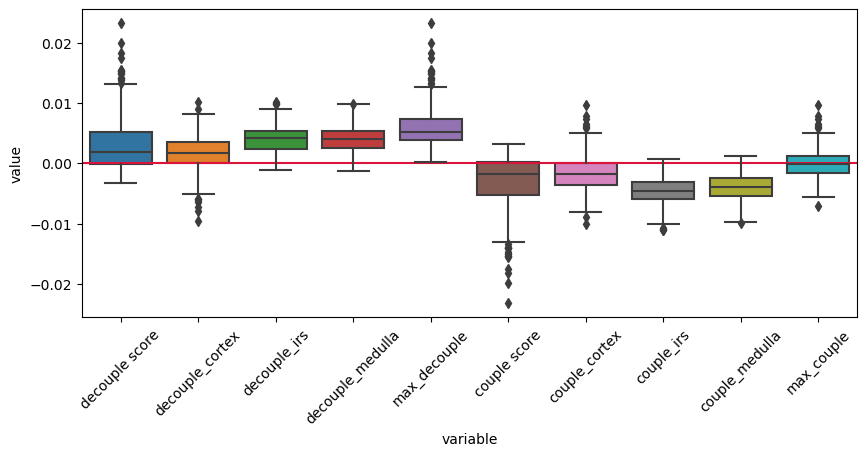

In [745]:
plt.figure(figsize=(10,4))
plt.axhline(y=0.0, color='crimson') 
sns.boxplot(data=score_df_melt, x="variable", y="value")
plt.xticks(rotation=45)

In [79]:
cell_cycle_df = pd.read_csv("hair_gene_peak/GO_term_summary_20240116_095743.txt", sep="\t")
cell_cycle_genes = cell_cycle_df["MGI Gene/Marker ID"].to_list()

In [80]:
cell_cycle_genes = [e.upper() for e in cell_cycle_genes]


In [794]:
score_df[score_df["couple score"] > 0].gene

0         ENOX1
2         MAGI1
7       CCDC171
9        NUP153
27          UST
         ...   
103        ST14
106      TFAP2A
108    TNFRSF19
111      TRIM29
116      ZMYND8
Name: gene, Length: 77, dtype: object

In [797]:
path = "hair_gene_peak/couple_genes/"
couple_genes = score_df[score_df["couple score"] > 0].gene
for genename in couple_genes:
    get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X)
    save = path+genename+".jpg"
    smooth_gene_peaks_plot_interv(genename, "latent_time_8",2, points=500, save=save, ticks=False, gcolor="greenyellow", pcolor="darkviolet", title=False)
 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'decouple score'),
  Text(1, 0, 'decouple_cortex'),
  Text(2, 0, 'decouple_irs'),
  Text(3, 0, 'decouple_medulla'),
  Text(4, 0, 'max_decouple'),
  Text(5, 0, 'couple score'),
  Text(6, 0, 'couple_cortex'),
  Text(7, 0, 'couple_irs'),
  Text(8, 0, 'couple_medulla'),
  Text(9, 0, 'max_couple')])

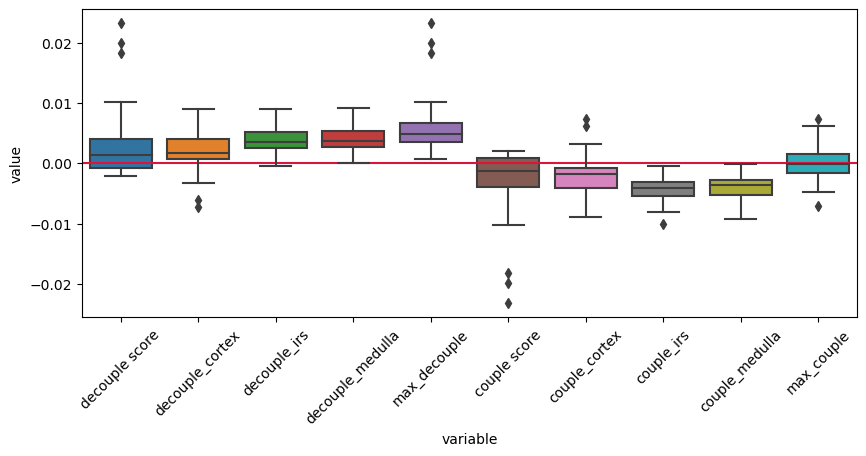

In [759]:
plt.figure(figsize=(10,4))
plt.axhline(y=0.0, color='crimson') 
sns.boxplot(data=cell_cycle_df, x="variable", y="value")
plt.xticks(rotation=45)

In [81]:
cell_cycle_genes = score_df[score_df.gene.isin(cell_cycle_genes) ].gene.to_list()
print(cell_cycle_genes)



['DCTN1', 'WNT5A', 'BLM', 'CDC25A', 'CENPC1', 'TOPBP1', 'EXOC6B', 'BRD8', 'PTCH1', 'RPTOR', 'INCENP', 'PPP1R12A', 'CPSF3', 'LIG1', 'SDCCAG8', 'MKI67', 'SMPD3', 'CEP164', 'EDNRA', 'SMC2', 'MCM4', 'TXNIP', 'ACVR1B', 'ADARB1', 'AZIN1', 'CTDSP2', 'DAB2IP', 'FGFR1', 'FGFR2', 'FGFR3', 'LEF1', 'MICAL3', 'OVOL1', 'PRKCD', 'SIK1', 'TACC2', 'TRP53BP2']


In [84]:

path = "hair_gene_peak/cellcycle/"
for genename in cell_cycle_genes:
    warnings.filterwarnings('ignore')
    get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X)
    save = path+genename+".jpg"
    try:
        smooth_gene_peaks_plot_interv(genename, time="latent_time_8", rna_data=rna_data, linewidth=1, ticks=True, title=True, gcolor="greenyellow", pcolor="darkviolet",save=save)
    except:
        print(genename)   

BLM
INCENP
SMPD3
FGFR1


In [20]:
cortexrna = rna_data[(rna_data.obs.celltype!="IRS")]
cortexrna = cortexrna[(cortexrna.obs.celltype!="Medulla")]
cortexatac = atac_data[(atac_data.obs.celltype!="IRS")]
cortexatac = cortexatac[(cortexatac.obs.celltype!="Medulla")]
decouple_score_cortex = []
couple_score_cortex = []

irsrna = rna_data[(rna_data.obs.celltype!="Hair Shaft-cuticle.cortex")]
irsrna = irsrna[(irsrna.obs.celltype!="Medulla")]
irsatac = atac_data[(atac_data.obs.celltype!="Hair Shaft-cuticle.cortex")]
irsatac = irsatac[(irsatac.obs.celltype!="Medulla")]
decouple_score_irs = []
couple_score_irs = []

medullarna = rna_data[(rna_data.obs.celltype!="Hair Shaft-cuticle.cortex")]
medullarna = medullarna[(medullarna.obs.celltype!="IRS")]
medullaatac = atac_data[(atac_data.obs.celltype!="Hair Shaft-cuticle.cortex")]
medullaatac = medullaatac[(medullaatac.obs.celltype!="IRS")]

non_m_rna = rna_data[(rna_data.obs.celltype!="Medulla")]
non_m_atac = atac_data[(atac_data.obs.celltype!="Medulla")]

decouple_score_irs = []
couple_score_irs = []

decouple_score_medulla = []
couple_score_medulla = []

decouple_scores = []
couple_scores = []

genelist = score_df.gene.to_list()
failed = []
from tqdm import tqdm



In [21]:
for i in tqdm(range(len(genelist))):
    genename = genelist[i]
    time = "latent_time_8"
    width= 1e-3
    try: 

        decouple_score_c, _, _, couple_score_c = gene_level_casual_nonzero(genename,time, litemodel,cortexrna,cortexatac, norm_X=cortexatac.layers["norm"],width=width, thresh=1e-5)
        decouple_score_cortex.append(decouple_score_c)
        couple_score_cortex.append(couple_score_c)
        # score_df[score_df.gene==genename]["decouple_cortex"] = decouple_score_c
        # score_df[score_df.gene==genename]["couple_cortex"] = couple_score_c

        decouple_score_i, _, _, couple_score_i = gene_level_casual_nonzero(genename,time, litemodel,irsrna,irsatac, norm_X=irsatac.layers["norm"],width=width, thresh=1e-5)
        decouple_score_irs.append(decouple_score_i)
        couple_score_irs.append(couple_score_i)
        # score_df[score_df.gene==genename]["decouple_irs"] = decouple_score_i
        # score_df[score_df.gene==genename]["couple_irs"] = couple_score_i


        decouple_score_m, _, _, couple_score_m = gene_level_casual_nonzero(genename,time, litemodel,medullarna,medullaatac, norm_X=medullaatac.layers["norm"],width=width, thresh=1e-5)
        decouple_score_medulla.append(decouple_score_m)
        couple_score_medulla.append(couple_score_m)
        # score_df[score_df.gene==genename]["decouple_medulla"] = decouple_score_m
        # score_df[score_df.gene==genename]["couple_medulla"] = couple_score_m


        decouple_score, _, _, couple_score = gene_level_casual_nonzero(genename,time, litemodel,rna_data,atac_data, norm_X=atac_data.layers["norm"],width=width, thresh=1e-5)
        decouple_scores.append(decouple_score)
        couple_scores.append(couple_score)
        # score_df[score_df.gene==genename]["decouple score"] = decouple_score
        # score_df[score_df.gene==genename]["couple score"] = couple_score
    except:
        print(genename)
        failed.append(genename)

score_df2 = pd.DataFrame({"gene":genelist, "decouple_score": decouple_scores, "couple_score":couple_scores, 
"decouple_cortex":decouple_score_cortex, "couple_cortex":couple_score_cortex, "decouple_irs":decouple_score_irs, 
"couple_irs":couple_score_irs, "decouple_medulla":decouple_score_medulla, "couple_medulla":couple_score_medulla})
score_df2


100%|██████████| 275/275 [15:10:16<00:00, 198.61s/it]  


,Unnamed: 0,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medulla,max_decouple,super_enhancer
0,0,ENOX1,0.001780,-0.001790,-0.001249,0.001239,-0.005405,0.005395,0.000315,-0.000325,0.001780,False
1,1,DCTN1,0.008109,-0.008119,-0.000975,0.000965,-0.000755,0.000745,0.000954,-0.000964,0.008109,False
2,2,MAGI1,-0.010356,0.010346,-0.004277,0.004267,-0.003956,0.003946,0.002723,-0.002733,0.002723,False
3,3,FBRSL1,0.013522,-0.013532,0.002461,-0.002471,0.008445,-0.008455,-0.002022,0.002012,0.013522,False
4,4,KIF15,0.022472,-0.022482,0.004977,-0.004987,0.005168,-0.005178,-0.000995,0.000985,0.022472,False
...,...,...,...,...,...,...,...,...,...,...,...,...
270,270,TRP53BP2,0.000149,-0.000159,0.000681,-0.000691,0.009492,-0.009502,-0.001870,0.001860,0.009492,True
271,271,VGLL4,-0.008372,0.008362,-0.005988,0.005978,0.005668,-0.005678,0.002600,-0.002610,0.005668,True
272,272,ZFAND5,0.000775,-0.000785,-0.000300,0.000290,0.005037,-0.005047,0.001559,-0.001569,0.005037,True
273,273,ZFP750,0.003907,-0.003917,0.001288,-0.001298,0.000656,-0.000666,0.000322,-0.000332,0.003907,True


In [22]:
score_df2.to_csv("hair_gene_peak/score_full_001.csv")

In [29]:
score_df2.sort_values("decouple_score", ascending=False).head(30)

,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medulla,super_enhancer
107,NTN1,0.018248,-0.018258,0.020831,-0.020841,0.012805,-0.012815,0.016618,-0.016628,False
257,SLC39A10,0.017626,-0.017636,0.016117,-0.016127,-0.002726,0.002716,0.016568,-0.016578,True
226,MYO18A,0.010100,-0.010110,0.006666,-0.006676,-0.004672,0.004662,0.010417,-0.010427,True
80,TOPBP1,0.009536,-0.009546,0.016233,-0.016243,0.007517,-0.007527,0.014781,-0.014791,False
125,MKI67,0.009301,-0.009311,0.008171,-0.008181,0.007532,-0.007542,0.009476,-0.009486,False
213,LEF1,0.008843,-0.008853,0.024591,-0.024601,-0.000720,0.000710,0.002438,-0.002448,True
19,LRP4,0.008454,-0.008464,-0.002725,0.002715,-0.003818,0.003808,0.010320,-0.010330,False
117,KRT75,0.008134,-0.008144,0.015988,-0.015998,-0.000187,0.000177,0.007075,-0.007085,False
224,MT1,0.007378,-0.007388,0.016870,-0.016880,0.008144,-0.008154,0.013386,-0.013396,True
67,MAF,0.006774,-0.006784,-0.001911,0.001901,-0.002399,0.002389,0.013627,-0.013637,False


In [52]:
score_df2.sort_values("couple_score", ascending=False).head(30)

,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medulla,super_enhancer,max_decouple,max_couple
239,PPP1R14C,-0.016586,0.016576,-0.020077,0.020067,-0.001806,0.001796,-0.007821,7.810932e-03,True,-0.001806,0.020067
178,DAB2IP,-0.016029,0.016019,0.006738,-0.006748,-0.005828,0.005818,0.007136,-7.145827e-03,True,0.007136,0.016019
171,CHD2,-0.015473,0.015463,-0.010224,0.010214,-0.012253,0.012243,-0.010241,1.023087e-02,True,-0.010224,0.015463
179,DDIT4,-0.015331,0.015321,-0.011479,0.011469,-0.009106,0.009096,-0.011986,1.197627e-02,True,-0.009106,0.015321
183,EGR3,-0.015316,0.015306,-0.009929,0.009919,-0.011997,0.011987,-0.000501,4.911978e-04,True,-0.000501,0.015306
21,MAP3K9,-0.015301,0.015291,-0.000762,0.000752,-0.006172,0.006162,0.008427,-8.437034e-03,False,0.008427,0.015291
187,FGFR1,-0.015034,0.015024,-0.018595,0.018585,-0.010868,0.010858,-0.004566,4.556105e-03,True,-0.004566,0.018585
115,CHD1L,-0.014818,0.014808,0.007424,-0.007434,-0.012776,0.012766,-0.003711,3.701463e-03,False,0.007424,0.014808
172,CHD6,-0.014244,0.014234,0.011234,-0.011244,0.000930,-0.000940,0.003913,-3.922950e-03,True,0.011234,0.014234
121,SDCCAG8,-0.014234,0.014224,-0.012666,0.012656,-0.017561,0.017551,-0.008494,8.483535e-03,False,-0.008494,0.017551


In [24]:
score_df = pd.read_csv("hair_gene_peak/score_full.csv")
score_df[["gene", "super_enhancer"]]

,gene,super_enhancer
0,ENOX1,False
1,DCTN1,False
2,MAGI1,False
3,FBRSL1,False
4,KIF15,False
...,...,...
270,TRP53BP2,True
271,VGLL4,True
272,ZFAND5,True
273,ZFP750,True


In [421]:
score_df.to_csv("hair_gene_peak/score_full_updated.csv")

In [25]:
score_df2 = pd.merge(left = score_df2, right=score_df[["gene", "super_enhancer"]], on="gene")
score_df2

,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medulla,super_enhancer
0,ENOX1,-0.010385,0.010375,0.000415,-0.000425,-0.008803,0.008793,-0.009288,0.009278,False
1,DCTN1,0.000782,-0.000792,0.002949,-0.002959,-0.008502,0.008492,-0.005527,0.005517,False
2,MAGI1,0.001516,-0.001526,0.005577,-0.005587,-0.002761,0.002751,0.000357,-0.000367,False
3,FBRSL1,-0.006040,0.006030,-0.002949,0.002939,-0.008857,0.008847,-0.014170,0.014160,False
4,KIF15,0.005116,-0.005126,0.019120,-0.019130,0.009126,-0.009136,0.012663,-0.012673,False
...,...,...,...,...,...,...,...,...,...,...
270,TRP53BP2,-0.009342,0.009332,0.008785,-0.008795,-0.003960,0.003950,0.012646,-0.012656,True
271,VGLL4,-0.008721,0.008711,-0.002690,0.002680,-0.003377,0.003367,-0.000960,0.000950,True
272,ZFAND5,-0.003675,0.003665,-0.008324,0.008314,-0.009355,0.009345,-0.017097,0.017087,True
273,ZFP750,-0.000437,0.000427,0.011929,-0.011939,0.003937,-0.003947,0.003308,-0.003318,True


In [27]:
score_df2[score_df2.gene=="DLX3"]

,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medulla,super_enhancer
180,DLX3,-0.005524,0.005514,-0.013791,0.013781,-0.009851,0.009841,-0.010812,0.010802,True


(None,)

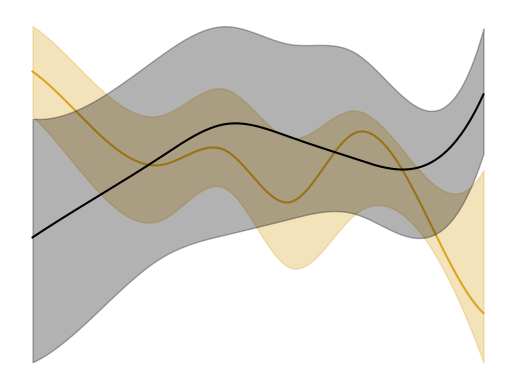

In [56]:
genename = "EGR3"
genename = genename.upper()
get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X=atac_data.layers["norm"])
smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= rna_data,linewidth = 2, points=500, pcolor="black", gcolor="goldenrod"), 

(None,)

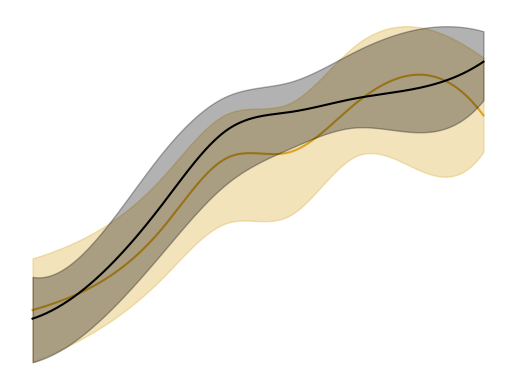

In [662]:
genename = "DLX3"
genename = genename.upper()
get_gene_local_atac(genename, litemodel,irsrna, irsatac, norm_X=irsatac.layers["norm"])
smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= irsrna,linewidth = 2, points=500, pcolor="black", gcolor="goldenrod"), 

In [28]:
TFs = []
with open("mouse_tf.txt") as f:
     for line in f:
        # Check if the line starts with ">MA"
        if line.startswith('>MA'):
            # Process the line (for now, just print it)
            line_list = line.strip().split('\t')
            gene = line_list[1]
            gene = gene.upper()
            TFs.append(gene)
TFs = pd.DataFrame({"TF":TFs})
TFs.to_csv("mouse_TFs.csv")

IndexError: list index out of range

In [566]:
score_df2[score_df2.gene.isin(TFs.TF)]

,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medulla,max_decouple,super_enhancer,max_couple
49,MEF2D,0.000733,-0.000743,-0.000135,0.000125,0.006422,-0.006432,-0.000441,0.000431,0.006422,False,0.000431
67,MAF,-0.004226,0.004216,-0.002176,0.002166,0.002340,-0.002350,0.003973,-0.003983,0.003973,False,0.004216
164,ATF3,-0.003949,0.003939,-0.000368,0.000358,0.002209,-0.002219,0.005000,-0.005010,0.005000,True,0.003939
176,CUX1,0.002761,-0.002771,-0.000703,0.000693,0.002147,-0.002157,0.003328,-0.003338,0.003328,True,0.000693
180,DLX3,-0.007343,0.007333,-0.005813,0.005803,-0.003173,0.003163,0.005030,-0.005040,0.005030,True,0.007333
183,EGR3,-0.017891,0.017881,-0.008749,0.008739,0.001847,-0.001857,0.002948,-0.002958,0.002948,True,0.017881
185,ERF,-0.005900,0.005890,-0.003740,0.003730,-0.001770,0.001760,-0.002523,0.002513,-0.001770,True,0.005890
196,GRHL1,0.005994,-0.006004,-0.000931,0.000921,-0.003765,0.003755,-0.004089,0.004079,0.005994,True,0.004079
197,GRHL2,0.003868,-0.003878,0.003810,-0.003820,-0.000979,0.000969,0.003764,-0.003774,0.003868,True,0.000969
200,HOXB6,0.009320,-0.009330,0.001922,-0.001932,0.002580,-0.002590,-0.003990,0.003980,0.009320,True,0.003980


(None,)

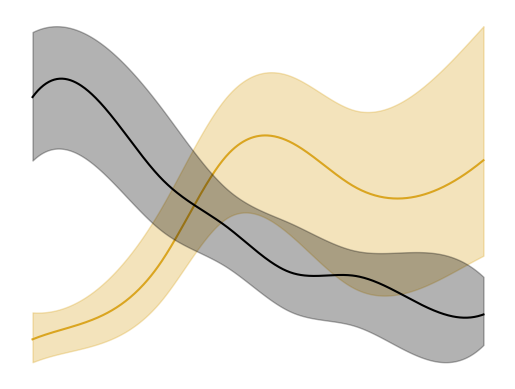

In [592]:
## IRS TF:  KLF6, MEF2D ERF HOXB6 OVOL1 RXRA SREBF2 TFAP2A
## IRS SE:  notch1 btg2 ctsc
genename = "CTSC"
genename = genename.upper()
get_gene_local_atac(genename, litemodel, irsrna, irsatac, norm_X=irsatac.layers["norm"])
smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= irsrna,linewidth = 2, points=500, pcolor="black", gcolor="goldenrod"), 

In [558]:
genename = "KLF6"
genename = genename.upper()
get_gene_local_atac(genename, litemodel, irsrna, irsatac, norm_X=irsatac.layers["norm"])
smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= irsrna,linewidth = 2, points=500, pcolor="black", gcolor="goldenrod"), 

['KLF6']

In [521]:
genes = ["NTN1"]
for genename in genes:
    # smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=irsrna, atac_data=irsatac, norm_X = irsatac.layers["norm"],
    # linewidth=1, gcolor="greenyellow", pcolor="darkviolet", save="hair_gene_peak/IRS/marker/"+genename+".jpg")
    get_gene_local_atac(genename, litemodel, irsrna, irsatac, norm_X=irsatac.layers["norm"])
    smooth_gene_peaks_plot_interv(genename,time="latent_time_8",rna_data= irsrna,linewidth = 2, points=500,gcolor="greenyellow", pcolor="darkviolet", save="hair_gene_peak/IRS/marker/"+genename+".jpg"),

In [682]:
gene_level_casual_nonzero("LEF1","latent_time_8", litemodel,cortexrna, cortexatac, norm_X=cortexatac.layers["norm"],width=0.001, thresh=1e-5)

(0.0006065622661518694,
 0.038648681115910646,
 0.039255243382062516,
 -0.0006165622661518694)

In [539]:
gene_level_casual("SREBF2","latent_time_10", litemodel,irsrna, irsatac, norm_X=irsatac.layers["norm"],width=0.1)


(0.001775962076826735, 0.025123612491715398, 0.023347650414888663)

In [427]:
score_df.to_csv("hair_gene_peak/score_full_updated.csv")

In [256]:
se_gene = pd.read_csv("hair_gene_peak/score_full.csv")
genelist = se_gene[se_gene.super_enhancer==True].gene.to_list()
path = "hair_gene_peak/super_enhancer/IRS/"
for genename in genelist:
    warnings.filterwarnings('ignore')
    smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=irsrna, atac_data=irsatac, norm_X = irsatac.layers["norm"],
        linewidth=1, ticks=False, title=False, gcolor="greenyellow", pcolor="darkviolet", save=path+genename+".jpg")

In [257]:
se_gene = pd.read_csv("hair_gene_peak/score_full.csv")
genelist = se_gene[se_gene.super_enhancer==True].gene.to_list()
path = "hair_gene_peak/super_enhancer/medulla/"
for genename in genelist:
    warnings.filterwarnings('ignore')
    smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=medullarna, atac_data=medullaatac, norm_X = medullaatac.layers["norm"],
        linewidth=1, ticks=False, title=False, gcolor="greenyellow", pcolor="darkviolet", save=path+genename+".jpg")

In [258]:
se_gene = pd.read_csv("hair_gene_peak/score_full.csv")
genelist = se_gene[se_gene.super_enhancer==True].gene.to_list()
path = "hair_gene_peak/super_enhancer/cortex/"
for genename in genelist:
    warnings.filterwarnings('ignore')
    smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=cortexrna, atac_data=cortexatac, norm_X = cortexatac.layers["norm"],
        linewidth=1, ticks=False, title=False, gcolor="greenyellow", pcolor="darkviolet", save=path+genename+".jpg")

In [255]:
se_gene = pd.read_csv("hair_gene_peak/score_full.csv")
genelist = se_gene[se_gene.super_enhancer==True].gene.to_list()
path = "hair_gene_peak/super_enhancer/all/"
for genename in genelist:
    warnings.filterwarnings('ignore')
    smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=rna_data, atac_data=atac_data, norm_X = atac_data.layers["norm"],
        linewidth=1, ticks=False, title=False, gcolor="greenyellow", pcolor="darkviolet", save=path+genename+".jpg")

In [38]:
score_df = score_df2[score_df2.super_enhancer==True]
score_df["max_decouple"] =  score_df[['decouple_score', 'decouple_medulla', 'decouple_cortex', "decouple_irs"]].max(axis=1)
score_df["max_couple"] =  score_df[['couple_score', 'couple_medulla', 'couple_cortex', "couple_irs"]].max(axis=1)
score_df_melt = pd.melt(score_df, id_vars=["gene"], 
value_vars=["decouple_score", "decouple_cortex","decouple_irs", "decouple_medulla", "max_decouple","couple_score","couple_cortex","couple_irs", "couple_medulla","max_couple"])
score_df_melt

,gene,variable,value
0,ABL2,decouple_score,-0.005697
1,ACVR1B,decouple_score,0.001309
2,ADARB1,decouple_score,-0.003166
3,AFF3,decouple_score,0.003459
4,AGPAT3,decouple_score,-0.003275
...,...,...,...
1165,TRP53BP2,max_couple,0.009332
1166,VGLL4,max_couple,0.008711
1167,ZFAND5,max_couple,0.017087
1168,ZFP750,max_couple,0.000427


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'decouple_score'),
  Text(1, 0, 'decouple_cortex'),
  Text(2, 0, 'decouple_irs'),
  Text(3, 0, 'decouple_medulla'),
  Text(4, 0, 'max_decouple'),
  Text(5, 0, 'couple_score'),
  Text(6, 0, 'couple_cortex'),
  Text(7, 0, 'couple_irs'),
  Text(8, 0, 'couple_medulla'),
  Text(9, 0, 'max_couple')])

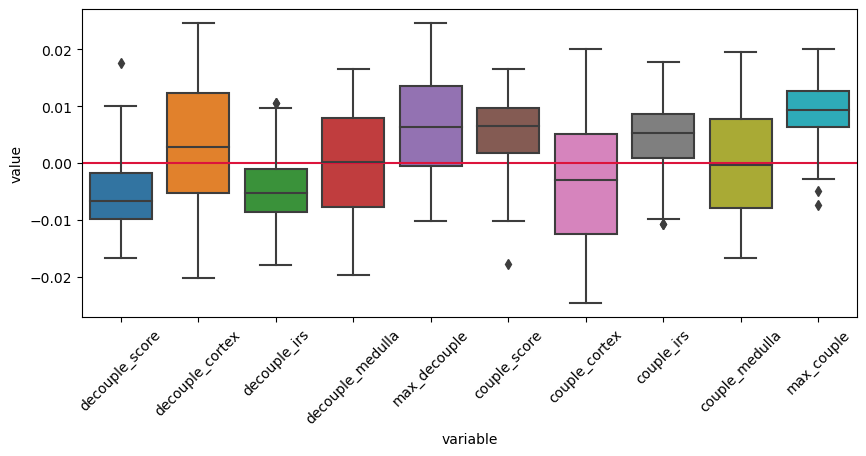

In [39]:
import seaborn as sns
plt.figure(figsize=(10,4))
plt.axhline(y=0.0, color='crimson') 
sns.boxplot(data=score_df_melt, x="variable", y="value")
plt.xticks(rotation=45)

In [113]:
score_df2 = pd.DataFrame({"gene":score_df.gene, "couple_score": couple_scores, "decouple_score": decouple_scores, "decouple_irs":decouple_score_irs, 
                        "couple_irs":couple_score_irs, "decouple_cortex":decouple_score_cortex, "couple_cortex":couple_score_cortex, 
                        "decouple_medulla":decouple_score_medulla, "couple_medulla":couple_score_medulla})
score_df2                        

,gene,couple_score,decouple_score,decouple_irs,couple_irs,decouple_cortex,couple_cortex,decouple_medulla,couple_medulla
0,ENOX1,-0.005306,0.005296,-0.006117,0.006107,0.005971,-0.005981,-0.001292,0.001282
1,DCTN1,-0.002297,0.002287,-0.001700,0.001690,-0.000512,0.000502,0.001317,-0.001327
2,MAGI1,0.016544,-0.016554,-0.001090,0.001080,-0.007149,0.007139,0.003968,-0.003978
3,FBRSL1,-0.000407,0.000397,0.006046,-0.006056,0.001441,-0.001451,0.009925,-0.009935
4,KIF15,-0.001201,0.001191,-0.000779,0.000769,0.001461,-0.001471,0.002616,-0.002626
...,...,...,...,...,...,...,...,...,...
112,TRP53BP2,-0.004417,0.004407,0.006183,-0.006193,0.004001,-0.004011,-0.003781,0.003771
113,VGLL4,-0.000667,0.000657,0.006380,-0.006390,0.004686,-0.004696,0.004370,-0.004380
114,ZFAND5,0.002957,-0.002967,-0.001430,0.001420,0.001426,-0.001436,0.001910,-0.001920
115,ZFP750,-0.014534,0.014524,0.016083,-0.016093,0.007929,-0.007939,0.001610,-0.001620


In [114]:
score_df2["max_decouple"] =  score_df2[['decouple_score', 'decouple_medulla', 'decouple_cortex', "decouple_irs"]].max(axis=1)
score_df2["max_couple"] =  score_df2[['couple_score', 'couple_medulla', 'couple_cortex', "couple_irs"]].max(axis=1)
score_df_melt2 = pd.melt(score_df2, id_vars=["gene"], 
value_vars=["decouple_score", "decouple_cortex","decouple_irs", "decouple_medulla", "max_decouple","couple_score","couple_cortex","couple_irs", "couple_medulla","max_couple"])
score_df_melt2

,gene,variable,value
0,ENOX1,decouple_score,0.005296
1,DCTN1,decouple_score,0.002287
2,MAGI1,decouple_score,-0.016554
3,FBRSL1,decouple_score,0.000397
4,KIF15,decouple_score,0.001191
...,...,...,...
2745,TRP53BP2,max_couple,0.003771
2746,VGLL4,max_couple,-0.000667
2747,ZFAND5,max_couple,0.002957
2748,ZFP750,max_couple,-0.001620


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'decouple score'),
  Text(1, 0, 'decouple_cortex'),
  Text(2, 0, 'decouple_irs'),
  Text(3, 0, 'decouple_medulla'),
  Text(4, 0, 'max_decouple'),
  Text(5, 0, 'couple score'),
  Text(6, 0, 'couple_cortex'),
  Text(7, 0, 'couple_irs'),
  Text(8, 0, 'couple_medulla'),
  Text(9, 0, 'max_couple')])

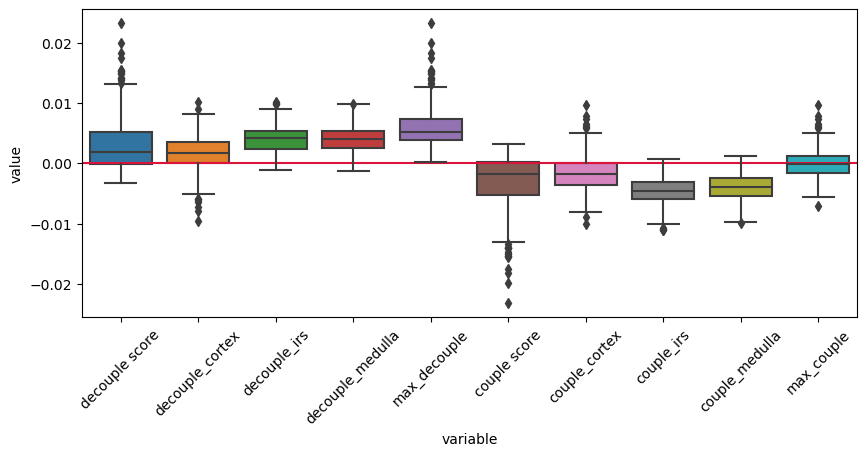

In [115]:
plt.figure(figsize=(10,4))
plt.axhline(y=0.0, color='crimson') 
sns.boxplot(data=score_df_melt, x="variable", y="value")
plt.xticks(rotation=45)

In [116]:
score_df2.to_csv("hair_gene_peak/score_full_new.csv")

In [430]:
score_en = score_df[score_df.super_enhancer==True]
score_en_melt = pd.melt(score_en, id_vars=["gene"], 
value_vars=["decouple_score", "decouple_cortex","decouple_irs", "decouple_medulla", "max_decouple","couple_score","couple_cortex","couple_irs", "couple_medulla","max_couple"])
score_en_melt


,gene,variable,value
0,ABL2,decouple_score,0.015079
1,ACVR1B,decouple_score,-0.004606
2,ADARB1,decouple_score,-0.002629
3,AFF3,decouple_score,-0.000649
4,AGPAT3,decouple_score,0.000335
...,...,...,...
1165,TRP53BP2,max_couple,0.001860
1166,VGLL4,max_couple,0.008362
1167,ZFAND5,max_couple,0.000290
1168,ZFP750,max_couple,-0.000332


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'decouple_score'),
  Text(1, 0, 'decouple_cortex'),
  Text(2, 0, 'decouple_irs'),
  Text(3, 0, 'decouple_medulla'),
  Text(4, 0, 'max_decouple'),
  Text(5, 0, 'couple_score'),
  Text(6, 0, 'couple_cortex'),
  Text(7, 0, 'couple_irs'),
  Text(8, 0, 'couple_medulla'),
  Text(9, 0, 'max_couple')])

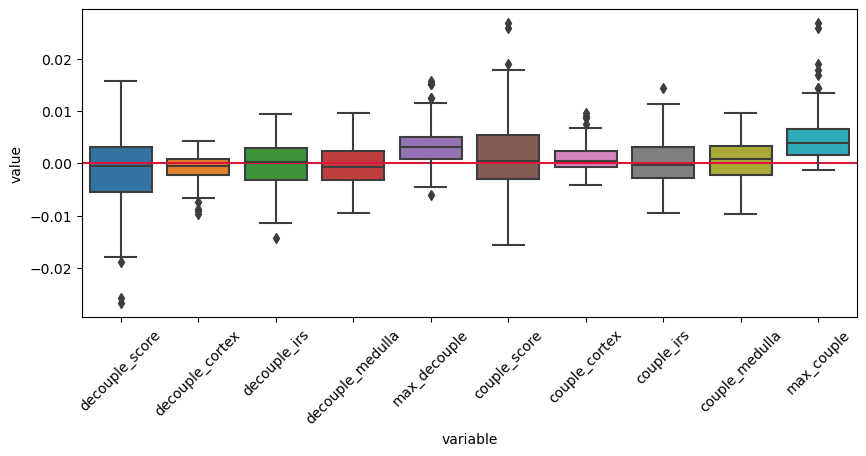

In [431]:
plt.figure(figsize=(10,4))
plt.axhline(y=0.0, color='crimson') 
sns.boxplot(data=score_en_melt, x="variable", y="value")
plt.xticks(rotation=45)

In [708]:

score_cc = score_df[score_df.gene.isin(["LEF1", "PXN", "SAFB", "AZIN1", "LRX2", "MBD2"])]
score_cc


,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medulla,max_decouple,super_enhancer,max_couple,couple_medula
166,AZIN1,0.000997,-0.001007,0.001237,-0.001247,0.003499,-0.003509,-0.002456,0.002446,0.003499,True,0.002446,NaN
220,MBD2,0.010696,-0.010706,0.000969,-0.000979,0.003358,-0.003368,-0.001425,0.001415,0.010696,True,0.001415,NaN
244,PXN,0.015229,-0.015239,0.001950,-0.001960,0.004427,-0.004437,-0.002171,0.002161,0.015229,True,0.002161,NaN
250,SAFB,-0.001442,0.001432,0.001300,-0.001310,-0.002820,0.002810,0.001577,-0.001587,0.001577,True,0.002810,NaN
0,LEF1,0.000587,-0.000597,0.000388,-0.000398,0.002553,-0.002563,0.002444,NaN,NaN,NaN,NaN,-0.002454


In [710]:
score_cc_melt = pd.melt(score_cc, id_vars=["gene"], 
value_vars=["decouple_score", "decouple_cortex","decouple_irs", "decouple_medulla", "max_decouple","couple_score","couple_cortex","couple_irs", "couple_medulla","max_couple"])
score_cc_melt

,gene,variable,value
0,AZIN1,decouple_score,0.000997
1,MBD2,decouple_score,0.010696
2,PXN,decouple_score,0.015229
3,SAFB,decouple_score,-0.001442
4,LEF1,decouple_score,0.000587
5,AZIN1,decouple_cortex,0.001237
6,MBD2,decouple_cortex,0.000969
7,PXN,decouple_cortex,0.001950
8,SAFB,decouple_cortex,0.001300
9,LEF1,decouple_cortex,0.000388


In [433]:
score_cc_melt.to_csv("decouple_overall_scores.csv")

In [711]:
plt.figure(figsize=(10,4))

# for template in ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
fig = px.line_polar(score_cc_melt, r="value", theta="variable", color="gene", line_close=True, markers=True,
                        color_discrete_sequence=px.colors.qualitative.Set3, range_r=[-0.01, 0.02], template="plotly_white")
    # fig = go.Figure()
fig.add_trace(go.Scatterpolar(
                name="0.0",
                mode = "lines",
                r = [0]*11,
                theta = ["decouple_score", "decouple_cortex","decouple_irs", "decouple_medulla", "max_decouple","couple_score","couple_cortex","couple_irs", "couple_medulla","max_couple", "decouple_score"],
                line_color = "black",
                line_shape = "spline",
                hoverinfo = "skip",
                showlegend = True))

fig.write_image("hair_gene_peak/cortex_decouple_score_polar.pdf")

<Figure size 1000x400 with 0 Axes>

In [131]:
score_df[score_df.gene.isin(["BLM", "FGFR1", "SIK1", "BTG2", "DLX3", "DNAJB1", "NOTCH1", "MYO18A", "ABL2"])]

,gene,decouple score,couple score,decouple_irs,couple_irs,decouple_medulla,couple_medulla,decouple_cortex,couple_cortex,super_enhancer,max_decouple,max_couple
18,BLM,0.003275,-0.003285,0.000936,-0.001936,0.000989,-0.000999,0.001140,-0.001150,False,0.003275,-0.000999
0,ABL2,0.012185,-0.012195,0.002398,-0.002408,0.002398,-0.002408,-0.001876,0.001866,True,0.012185,0.001866
11,BTG2,0.002733,-0.002743,0.005464,-0.005474,0.005464,-0.005474,-0.007845,0.007835,True,0.005464,0.007835
22,DLX3,0.009419,-0.009429,0.005957,-0.005967,0.005957,-0.005967,-0.001332,0.001322,True,0.009419,0.001322
23,DNAJB1,0.012668,-0.012678,0.002335,-0.002345,0.002335,-0.002345,0.000612,-0.000622,True,0.012668,-0.000622
29,FGFR1,-0.001705,0.001695,0.004405,-0.004415,0.004405,-0.004415,0.001708,-0.001718,True,0.004405,0.001695
68,MYO18A,0.002243,-0.002253,0.001700,-0.001710,0.001700,-0.001710,0.002868,-0.002878,True,0.002868,-0.001710
72,NOTCH1,0.002210,-0.002220,0.000601,-0.000611,0.000601,-0.000611,-0.002951,0.002941,True,0.002210,0.002941
96,SIK1,0.010228,-0.010238,0.005319,-0.005329,0.005319,-0.005329,0.001591,-0.001601,True,0.010228,-0.001601


In [145]:
# cellcycle genes
score_cc = score_df[score_df.super_enhancer==False]
score_cc = score_cc[score_cc.gene.isin(cell_cycle_genes)]
score_cc_melt = pd.melt(score_cc, id_vars=["gene"], 
value_vars=["decouple score", "decouple_cortex","decouple_irs", "decouple_medulla", "max_decouple","couple score","couple_cortex","couple_irs", "couple_medulla","max_couple"])
score_cc_melt

,gene,variable,value
0,DCTN1,decouple score,0.018243
1,WNT5A,decouple score,0.004818
2,BLM,decouple score,0.003275
3,CDC25A,decouple score,-0.001577
4,CENPC1,decouple score,-0.000729
...,...,...,...
215,CEP164,max_couple,-0.001631
216,EDNRA,max_couple,-0.001084
217,SMC2,max_couple,-0.000398
218,MCM4,max_couple,-0.002704


In [150]:
score_df[(score_df['decouple score']>0) & (score_df['decouple_irs']>0)
 & (score_df['decouple_cortex']>0) & (score_df['decouple_medulla']>0)].sort_values("decouple score", ascending=False)

,gene,decouple score,couple score,decouple_irs,couple_irs,decouple_medulla,couple_medulla,decouple_cortex,couple_cortex,super_enhancer,max_decouple,max_couple
104,PPP1R12A,0.023221,-0.023231,0.002889,-0.003889,0.003445,-0.003455,0.004290,-0.004300,False,0.023221,-0.003455
1,DCTN1,0.018243,-0.018253,0.006778,-0.007778,0.008291,-0.008301,0.007041,-0.007051,False,0.018243,-0.007051
38,TFG,0.015517,-0.015527,0.004899,-0.005899,0.006633,-0.006643,0.002587,-0.002597,False,0.015517,-0.002597
4,KIF15,0.015386,-0.015396,0.001594,-0.002594,0.001483,-0.001493,0.003783,-0.003793,False,0.015386,-0.001493
19,LRP4,0.015327,-0.015337,0.002748,-0.003748,0.004330,-0.004340,0.004200,-0.004210,False,0.015327,-0.003748
...,...,...,...,...,...,...,...,...,...,...,...,...
94,SGK1,0.000246,-0.000256,0.006640,-0.006650,0.006640,-0.006650,0.000016,-0.000026,True,0.006640,-0.000026
20,PCDH7,0.000243,-0.000253,0.004745,-0.005745,0.006263,-0.006273,0.003209,-0.003219,False,0.006263,-0.000253
129,2610507B11RIK,0.000128,-0.000138,0.005501,-0.006501,0.003907,-0.003917,0.001370,-0.001380,False,0.005501,-0.000138
70,RNF115,0.000060,-0.000070,0.010041,-0.011041,0.009875,-0.009885,0.003056,-0.003066,False,0.010041,-0.000070


In [477]:
score_df[ (score_df['decouple_irs']>0)].sort_values("decouple_irs", ascending=False)
 

,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medulla,max_decouple,super_enhancer,max_couple
71,MPHOSPH8,0.020388,-0.020398,0.001347,-0.001357,0.012603,-0.012613,0.011798,-0.011808,0.020388,False,-0.001357
17,NOL8,0.001646,-0.001656,0.000355,-0.000365,0.011740,-0.011750,0.006977,-0.006987,0.011740,False,-0.000365
125,MKI67,0.007768,-0.007778,0.002934,-0.002944,0.010776,-0.010786,0.006945,-0.006955,0.010776,False,-0.002944
107,NTN1,0.001272,-0.001282,0.000892,-0.000902,0.010500,-0.010510,0.008688,-0.008698,0.010500,False,-0.000902
10,LTBP3,-0.002639,0.002629,0.000055,-0.000065,0.009998,-0.010008,0.004142,-0.004152,0.009998,False,0.002629
...,...,...,...,...,...,...,...,...,...,...,...,...
191,FNBP1,-0.000789,0.000779,-0.000610,0.000600,0.000363,-0.000373,-0.003081,0.003071,0.000363,True,0.003071
230,NOTCH1,-0.001688,0.001678,0.000753,-0.000763,0.000250,-0.000260,-0.008442,0.008432,0.000753,True,0.008432
33,ZFP185,-0.003975,0.003965,-0.001754,0.001744,0.000161,-0.000171,-0.000974,0.000964,0.000161,False,0.003965
195,GOLIM4,0.001950,-0.001960,0.000605,-0.000615,0.000144,-0.000154,0.000837,-0.000847,0.001950,True,-0.000154


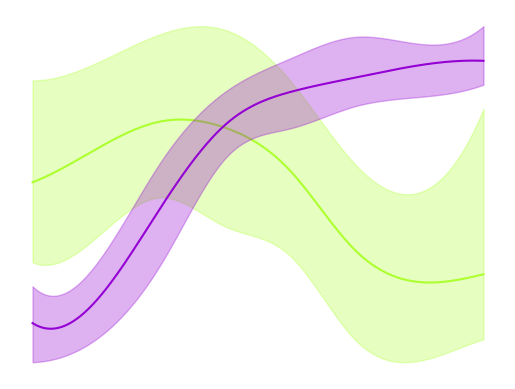

In [479]:
get_gene_local_atac("NOTCH1", litemodel, irsrna, irsatac, norm_X=irsatac.layers["norm"])
smooth_gene_peaks_plot_interv(genename, time="latent_time_8", rna_data=irsrna, linewidth=1, ticks=True, title=True, gcolor="greenyellow", pcolor="darkviolet")

In [71]:
irs_df = score_df[(score_df['decouple score']<0) & (score_df['decouple_irs']>0)].sort_values("decouple_irs", ascending=False)

In [111]:
irs_df.to_csv("hair_gene_peak/IRS_decouple.csv")

In [101]:
import warnings
path = "hair_gene_peak/IRS/marker/"
for genename in ["MT2", "CTSC", "KRT71", "KRT28", "TCHH", "BAMBI"]:
    warnings.filterwarnings('ignore')
    save = path+genename+".jpg"
    try:
        get_gene_local_atac(genename, litemodel, irsrna, irsatac, norm_X=irsatac.layers["norm"])

        smooth_gene_peaks_plot_interv(genename, time="latent_time_8", rna_data=irsrna, linewidth=1, ticks=True, title=True, gcolor="greenyellow", pcolor="darkviolet",save=save)
    except:
        print(genename)   

In [110]:
import warnings
path = "hair_gene_peak/IRS/marker/TF/"
for genename in ["CUX1", "GRHL1", "GATA3", "MAF"]:
    warnings.filterwarnings('ignore')
    save = path+genename+".jpg"
    try:
        get_gene_local_atac(genename, litemodel, irsrna, irsatac, norm_X=irsatac.layers["norm"])

        smooth_gene_peaks_plot_interv(genename, time="latent_time_8", rna_data=irsrna, linewidth=1, ticks=True, title=True, gcolor="greenyellow", pcolor="darkviolet",save=save)
    except:
        print(genename)   

In [309]:
[e for e in rna_data.var.index if "KITL" in e]

['KITL']

In [340]:
path="hair_gene_peak/super_enhancer/decouple/"
genename = "LEF1"
smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=rna_data, atac_data=atac_data, norm_X = atac_data.layers["norm"],
linewidth=1, ticks=True, title=True, gcolor="greenyellow", pcolor="darkviolet", save=path+genename+".jpg")

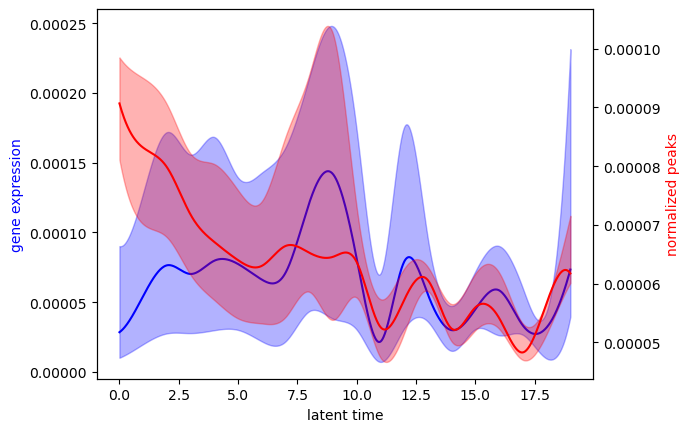

In [223]:
smooth_gene_peaks_plot_interv_2(genename, time="latent_time_cat", litemodel=litemodel, rna_data=non_m_rna, atac_data=non_m_atac, norm_X = non_m_atac.layers["norm"],linewidth=1, ticks=True, title=True)

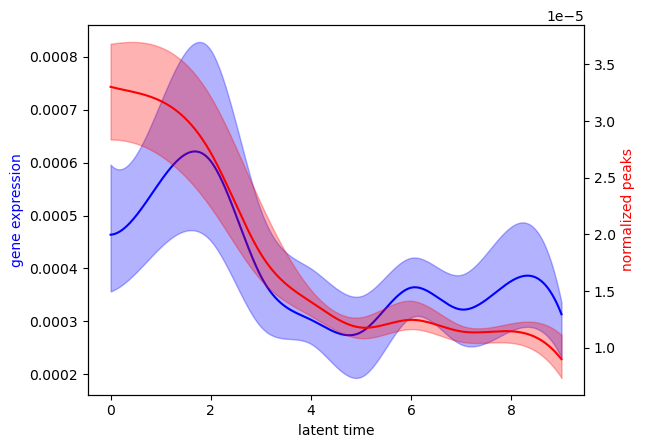

In [353]:
genename = "DCN"
# get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X=atac_data.layers["norm"])
smooth_gene_peaks_plot_interv_2(genename, time="latent_time_10", litemodel=litemodel, rna_data=irsrna, atac_data=irsatac, norm_X = irsatac.layers["norm"],linewidth=1, ticks=True, title=True)

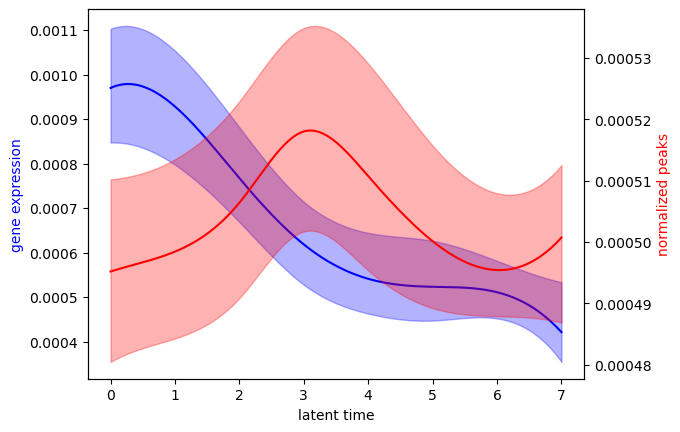

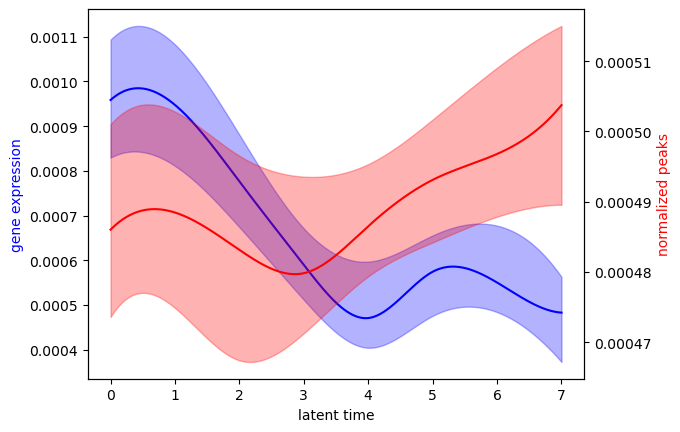

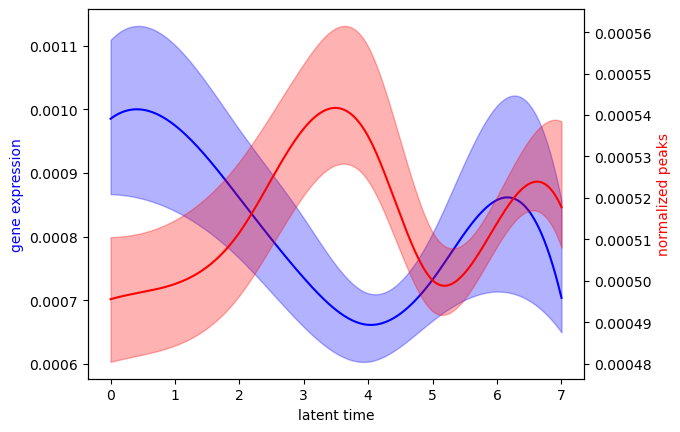

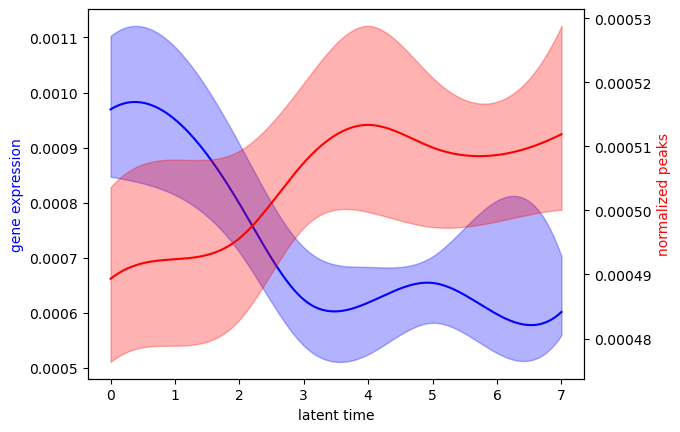

In [725]:
genename = "PTCH2"
smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=rna_data, atac_data=atac_data, norm_X = atac_data.layers["norm"],
linewidth=1, ticks=True, title=True)
smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=irsrna, atac_data=irsatac, norm_X = irsatac.layers["norm"],
linewidth=1, ticks=True, title=True)
smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=cortexrna, atac_data=cortexatac, norm_X = cortexatac.layers["norm"],
linewidth=1, ticks=True, title=True)
smooth_gene_peaks_plot_interv_2(genename, time="latent_time_8", litemodel=litemodel, rna_data=medullarna, atac_data=medullaatac, norm_X = medullaatac.layers["norm"],
linewidth=1, ticks=True, title=True)

In [355]:

genename = "DCN"
gene_level_casual_nonzero(genename,"latent_time", litemodel,rna_data=irsrna, atac_data=irsatac, norm_X=irsatac.layers["norm"],width=0.1, thresh=1e-5)

(0.00365789988333777,
 0.06952426470349804,
 0.07318216458683581,
 -0.00366789988333777)

In [712]:
score_df.sort_values("couple_score", ascending=False).head(5)

,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medulla,max_decouple,super_enhancer,max_couple,couple_medula
242,PTCH2,-0.026789,0.026779,-0.007452,0.007442,-0.004559,0.004549,-0.007046,0.007036,-0.004559,True,0.026779,NaN
184,EPHB6,-0.025845,0.025835,-0.009061,0.009051,-0.003459,0.003449,-0.001310,0.001300,-0.001310,True,0.025835,NaN
15,DSC2,-0.024458,0.024448,-0.002743,0.002733,0.008970,-0.008980,-0.015307,0.015297,0.008970,False,0.024448,NaN
56,PADI1,-0.023756,0.023746,-0.000580,0.000570,-0.004856,0.004846,-0.003179,0.003169,-0.000580,False,0.023746,NaN
28,CSGALNACT1,-0.021576,0.021566,-0.008538,0.008528,-0.001125,0.001115,0.002451,-0.002461,0.002451,False,0.021566,NaN


In [723]:
genelist = ["PTCH2"]
decouple_score_cortex=[]
couple_score_cortex = []
decouple_score_irs = []
couple_score_irs = []
decouple_score_medulla = []
couple_score_medulla = []
decouple_scores = []
couple_scores = []
time="latent_time"
width=1e-3
for i in tqdm(range(len(genelist))):
    genename = genelist[i]
    try: 

        decouple_score_c, _, _, couple_score_c = gene_level_casual_nonzero(genename,time, litemodel,cortexrna,cortexatac, norm_X=cortexatac.layers["norm"],width=width, thresh=1e-5)
        decouple_score_cortex.append(decouple_score_c)
        couple_score_cortex.append(couple_score_c)

        decouple_score_i, _, _, couple_score_i = gene_level_casual_nonzero(genename,time, litemodel,irsrna,irsatac, norm_X=irsatac.layers["norm"],width=width, thresh=1e-5)
        decouple_score_irs.append(decouple_score_i)
        couple_score_irs.append(couple_score_i)


        decouple_score_m, _, _, couple_score_m = gene_level_casual_nonzero(genename,time, litemodel,medullarna,medullaatac, norm_X=medullaatac.layers["norm"],width=width, thresh=1e-5)
        decouple_score_medulla.append(decouple_score_m)
        couple_score_medulla.append(couple_score_m)



        decouple_score, _, _, couple_score = gene_level_casual_nonzero(genename,time, litemodel,rna_data,atac_data, norm_X=atac_data.layers["norm"],width=width, thresh=1e-5)
        decouple_scores.append(decouple_score)
        couple_scores.append(couple_score)

    except:
        print(genename)
        failed.append(genename)

100%|██████████| 1/1 [03:31<00:00, 211.62s/it]


In [724]:
score_add = pd.DataFrame({"gene":genelist, "decouple_score": decouple_scores, "couple_score":couple_scores, 
"decouple_cortex":decouple_score_cortex, "couple_cortex":couple_score_cortex, "decouple_irs":decouple_score_irs, 
"couple_irs":couple_score_irs, "decouple_medulla":decouple_score_medulla, "couple_medula":couple_score_medulla})
score_add

,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medula
0,PTCH2,-0.002104,0.002094,-0.000611,0.000601,0.000068,-0.000078,-0.000373,0.000363


In [603]:
score_add["decouple_score"] = -score_add["decouple_score"]
score_add["couple_score"] = -score_add["couple_score"]
score_add["decouple_cortex"] = -score_add["decouple_cortex"]
score_add["couple_cortex"] = -score_add["couple_cortex"]
score_add["decouple_irs"] = -score_add["decouple_irs"]
score_add["couple_irs"] = -score_add["couple_irs"]
score_add["decouple_medulla"] = -score_add["decouple_medulla"]
score_add["couple_medula"] = -score_add["couple_medula"]
score_add


,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medula
0,CTSC,0.004216,-0.004206,0.000972,-0.000962,0.010803,-0.010793,0.006979,-0.006969


In [707]:
score_df = score_df.append(score_add)

In [365]:
gene_level_casual_nonzero("HTRA1","latent_time", litemodel,rna_data,atac_data, norm_X=atac_data.layers["norm"],width=0.1, thresh=1e-5)

(0.0006315830466405298,
 0.07283016416685328,
 0.07346174721349381,
 -0.0006415830466405298)

In [701]:
score_df[score_df.gene=="LEF1", score_add.columns[1:].to_list()] = score_add[score_add.gene=="LEF1", score_add.columns[1:].to_list()]
for col in  score_add.columns[1:].to_list():
    score_df[score_df.gene=="LEF1"][col] =  score_add[score_add.gene=="LEF1"][col]

TypeError: '(0    True
Name: gene, dtype: bool, ['decouple_score', 'couple_score', 'decouple_cortex', 'couple_cortex', 'decouple_irs', 'couple_irs', 'decouple_medulla', 'couple_medula'])' is an invalid key

In [704]:
score_df[score_df.gene=="LEF1"]

,gene,decouple_score,couple_score,decouple_cortex,couple_cortex,decouple_irs,couple_irs,decouple_medulla,couple_medulla,max_decouple,super_enhancer,max_couple,couple_medula


In [369]:
genename = "FAM120A"
decouple_score, _, _, couple_score = gene_level_casual_nonzero(genename,time, litemodel,rna_data,atac_data, norm_X=atac_data.layers["norm"],width=0.1, thresh=1e-5)
print(decouple_score, couple_score)
decouple_score_c, _, _, couple_score_c = gene_level_casual_nonzero(genename,time, litemodel,cortexrna,cortexatac, norm_X=cortexatac.layers["norm"],width=0.1, thresh=1e-5)
print(decouple_score_c, couple_score_c)
decouple_score_i, _, _, couple_score_i = gene_level_casual_nonzero(genename,time, litemodel,irsrna,irsatac, norm_X=irsatac.layers["norm"],width=0.1, thresh=1e-5)
print(decouple_score_i, couple_score_i)
decouple_score_m, _, _, couple_score_m = gene_level_casual_nonzero(genename,time, litemodel,medullarna,medullaatac, norm_X=medullaatac.layers["norm"],width=0.1, thresh=1e-5)
print(decouple_score_m, couple_score_m)

-0.016953392311757146 0.016943392311757146
-0.005883979485293622 0.005873979485293623
0.0011827212834132211 -0.0011927212834132212
0.0019092404468327856 -0.0019192404468327856


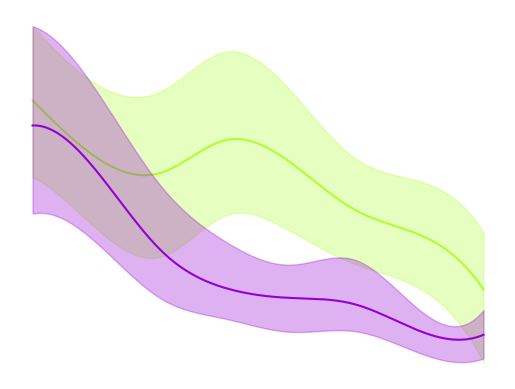

In [328]:
genename = "LEF1"
get_gene_local_atac(genename, litemodel, rna_data, atac_data, norm_X=atac_data.layers["norm"])
smooth_gene_peaks_plot_interv(genename, time="latent_time_8", rna_data=rna_data, linewidth=1, ticks=True, title=True, gcolor="greenyellow", pcolor="darkviolet")

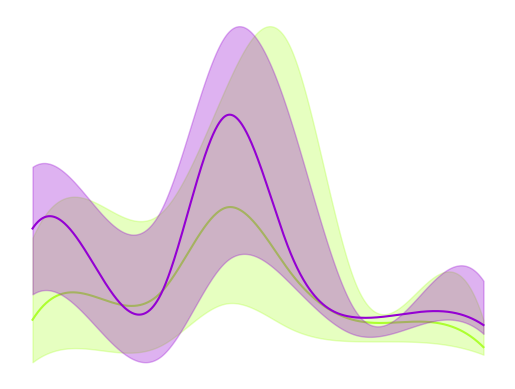

In [316]:
genename = ""
get_gene_local_atac(genename, litemodel, cortexrna, cortexatac, norm_X=cortexatac.layers["norm"])
smooth_gene_peaks_plot_interv(genename, time="latent_time_8", rna_data=cortexrna, linewidth=1, ticks=True, title=True, gcolor="greenyellow", pcolor="darkviolet")